### CGM Time series Analysis
#### Exploring trends and analysis. 
#### Bouns Technologies 

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

#### Import the data into the notebook

In [279]:
# UPDATE FILE NAME TO YOUR CSV
# Generally find that the first row of the data is not the headers, hence included the parameter header=1

file_path = './data/CGM data.csv'
cgm_df_uc = pd.read_csv(file_path, header=1)

# Understand the data types
# convert device timestamp to a datetime
cgm_df_uc.dtypes

Device                                object
Serial Number                         object
Device Timestamp                      object
Record Type                            int64
Historic Glucose mmol/L              float64
Scan Glucose mmol/L                  float64
Non-numeric Rapid-Acting Insulin     float64
Rapid-Acting Insulin (units)         float64
Non-numeric Food                     float64
Carbohydrates (grams)                float64
Carbohydrates (servings)             float64
Non-numeric Long-Acting Insulin      float64
Long-Acting Insulin Value (units)    float64
Notes                                float64
Strip Glucose mmol/L                 float64
Ketone mmol/L                        float64
Meal Insulin (units)                 float64
Correction Insulin (units)           float64
User Change Insulin (units)          float64
dtype: object

### Cleaning and preparing the data

In [280]:
# Understand the data types

# Convert device timestamp to a datetime
cgm_df_uc['Device Timestamp'] = pd.to_datetime(cgm_df_uc['Device Timestamp'], format='%d-%m-%Y %H:%M')

cgm_df_uc = cgm_df_uc.iloc[:,0:6].copy() # take all the rows of data and the first 6 columns

# there seems to be some duplicates in the rows of data - as can be seen in rows 54122 and 54123 
# 54127 rows in the original dataset 
# 52840 rows in the deduplicated dataset

cgm_df_uc = cgm_df_uc.drop_duplicates()

# understand the different scan types 
cgm_df_uc['Record Type'].value_counts()

# Understand what record type = 0 means 
# When the record type is 0, this uses the historic glucose measurement in the freestyle libre - this is computed passively and collected every 15 mins
# When the record type is 1, this is a scanned glucose and it means that the glucose has been manually scanned


# need to understand if scanned vs automatic is more effective

# cgm_df_uc[cgm_df_uc['Record Type'] == 0]
# cgm_df_uc[cgm_df_uc['Record Type'] == 1]
cgm_df_uc[(cgm_df_uc['Record Type']==0)|(cgm_df_uc['Record Type']==1)].sort_values(by='Device Timestamp').iloc[50020:50060,:]
# len(cgm_df_uc[(cgm_df_uc['Record Type']==0)|(cgm_df_uc['Record Type']==1)])

# extract the day, month, year from the device time stamp 
cgm_df_uc['day'] = cgm_df_uc['Device Timestamp'].dt.day
cgm_df_uc['year'] = cgm_df_uc['Device Timestamp'].dt.year
cgm_df_uc['month'] = cgm_df_uc['Device Timestamp'].dt.month

In [295]:
cgm_df_uc = cgm_df_uc[(cgm_df_uc['Record Type']==0)|(cgm_df_uc['Record Type']==1)]
cgm_df_uc.to_csv('./data/cgm_data_clean.csv')

### Visualise the data

Text(0.5, 0.98, 'Linegraph of historic and scanned glucose overtime')

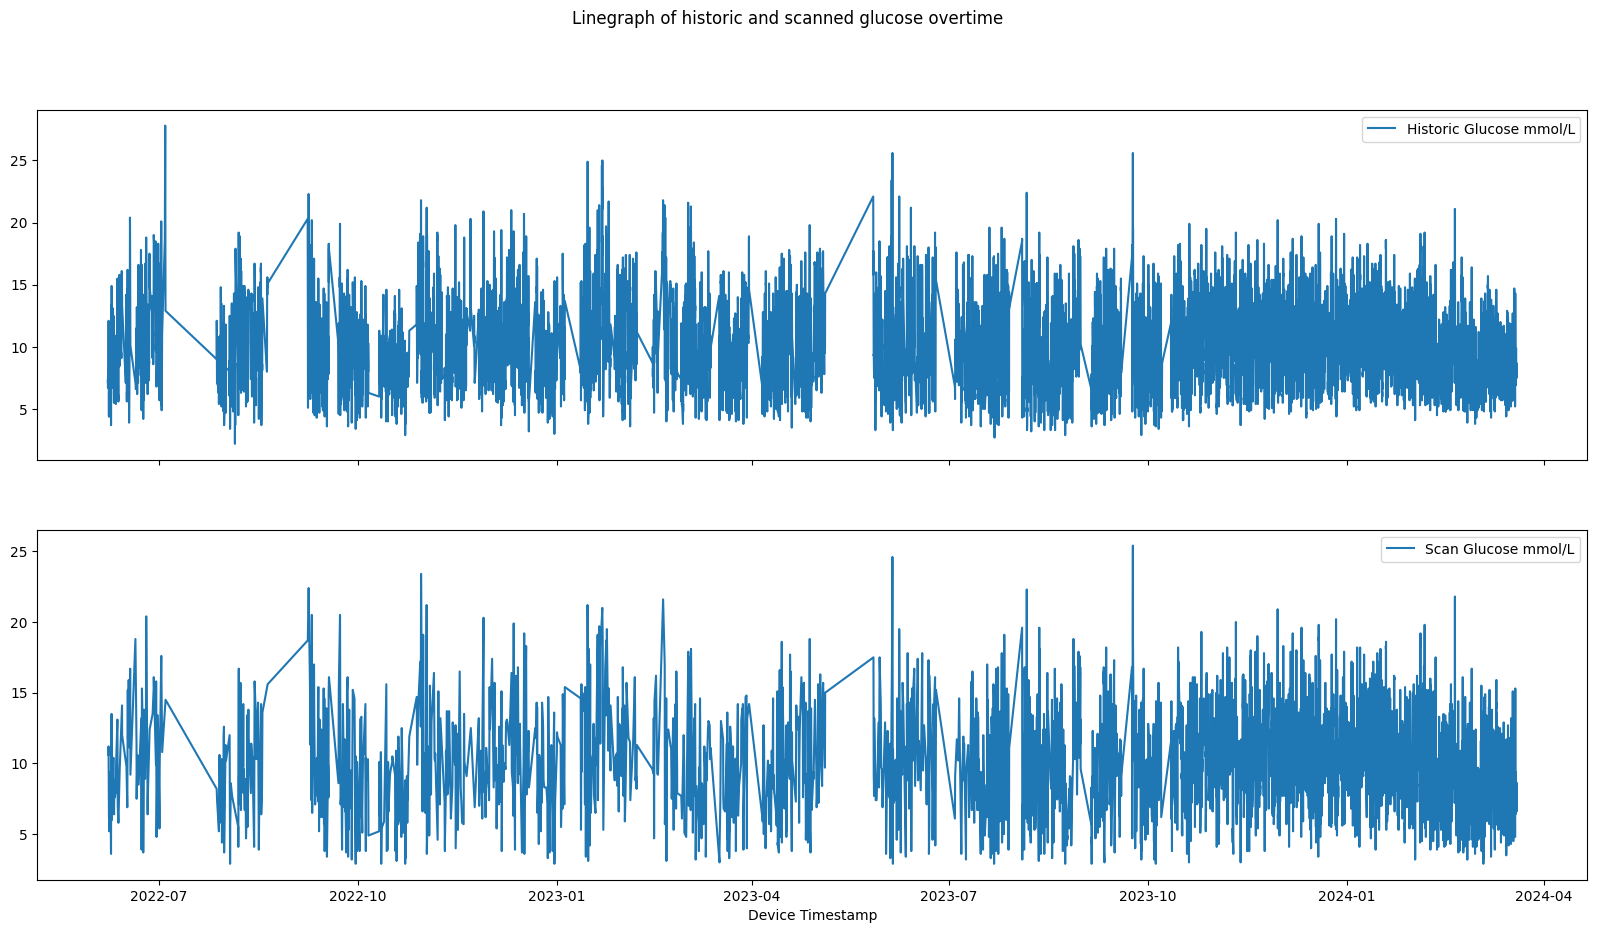

In [282]:
### Visualise the current data 

cgm_data_historic = cgm_df_uc[cgm_df_uc['Record Type']==0][['Historic Glucose mmol/L','Device Timestamp']].set_index('Device Timestamp')
cgm_data_scanned = cgm_df_uc[cgm_df_uc['Record Type']==1][['Scan Glucose mmol/L','Device Timestamp']].set_index('Device Timestamp')

cgm_data_scanned

fig, axs = plt.subplots(2,1, figsize=(20,10), sharex=True)
sns.lineplot(cgm_data_historic, ax=axs[0])
sns.lineplot(cgm_data_scanned, ax=axs[1])
plt.suptitle('Linegraph of historic and scanned glucose overtime')

#### Understanding the glucose readings statistical properties

Text(0.5, 1.0, 'Scanned glucose readings statistical view')

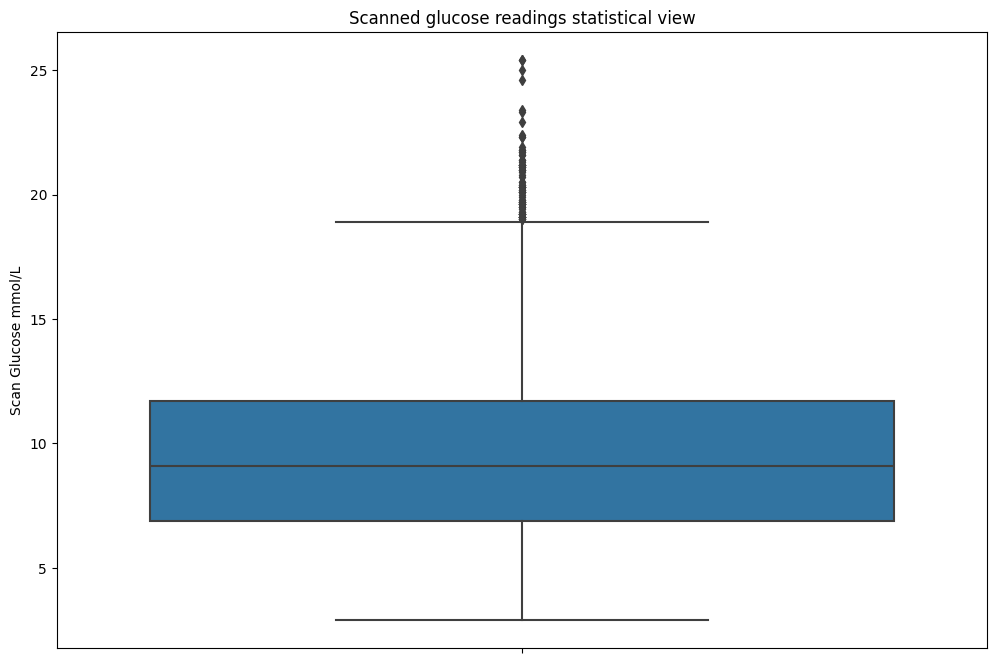

In [283]:
plt.figure(figsize=(12,8))
sns.boxplot(data=cgm_data_scanned, y='Scan Glucose mmol/L')
plt.title('Scanned glucose readings statistical view')

# median value lies close to 8/9 mmol/L

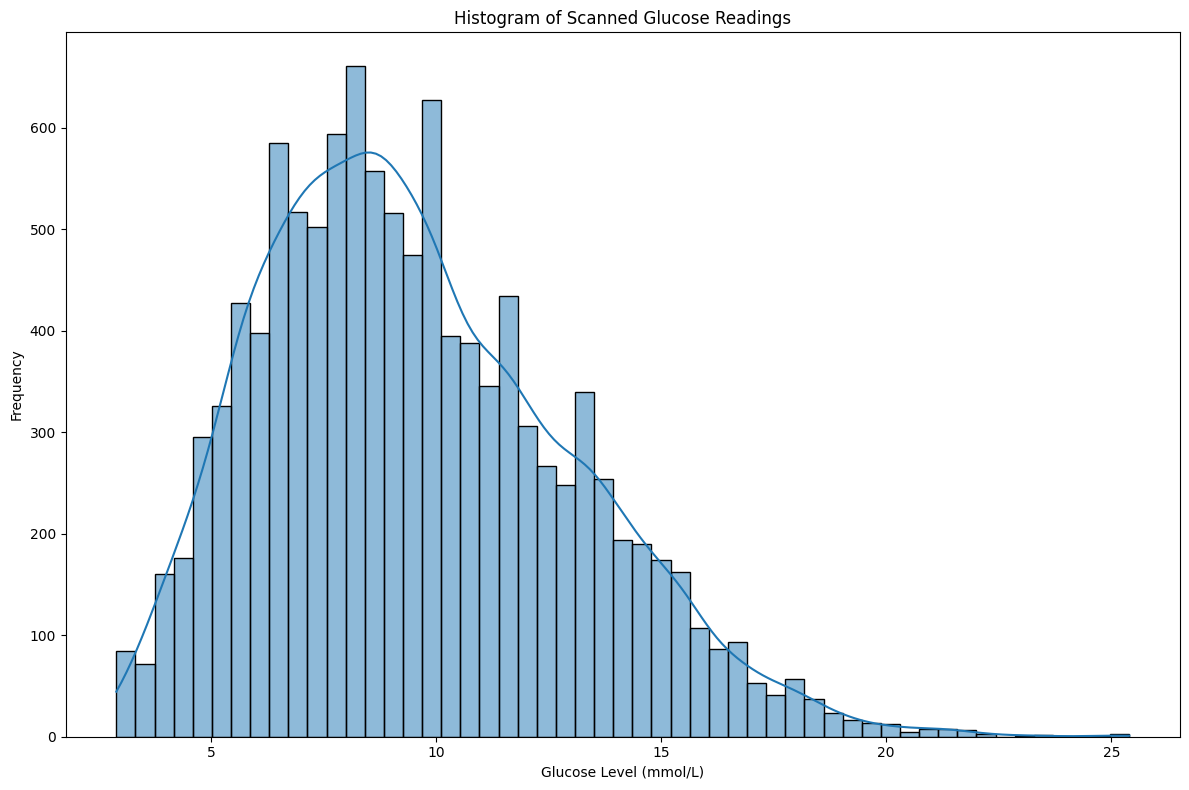

In [284]:
# understanding the distribution of scanned glucose readings

plt.figure(figsize=(12, 8))
sns.histplot(data=cgm_data_scanned['Scan Glucose mmol/L'], kde=True)
plt.title('Histogram of Scanned Glucose Readings')
plt.xlabel('Glucose Level (mmol/L)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Understand the daily and hourly differences in 

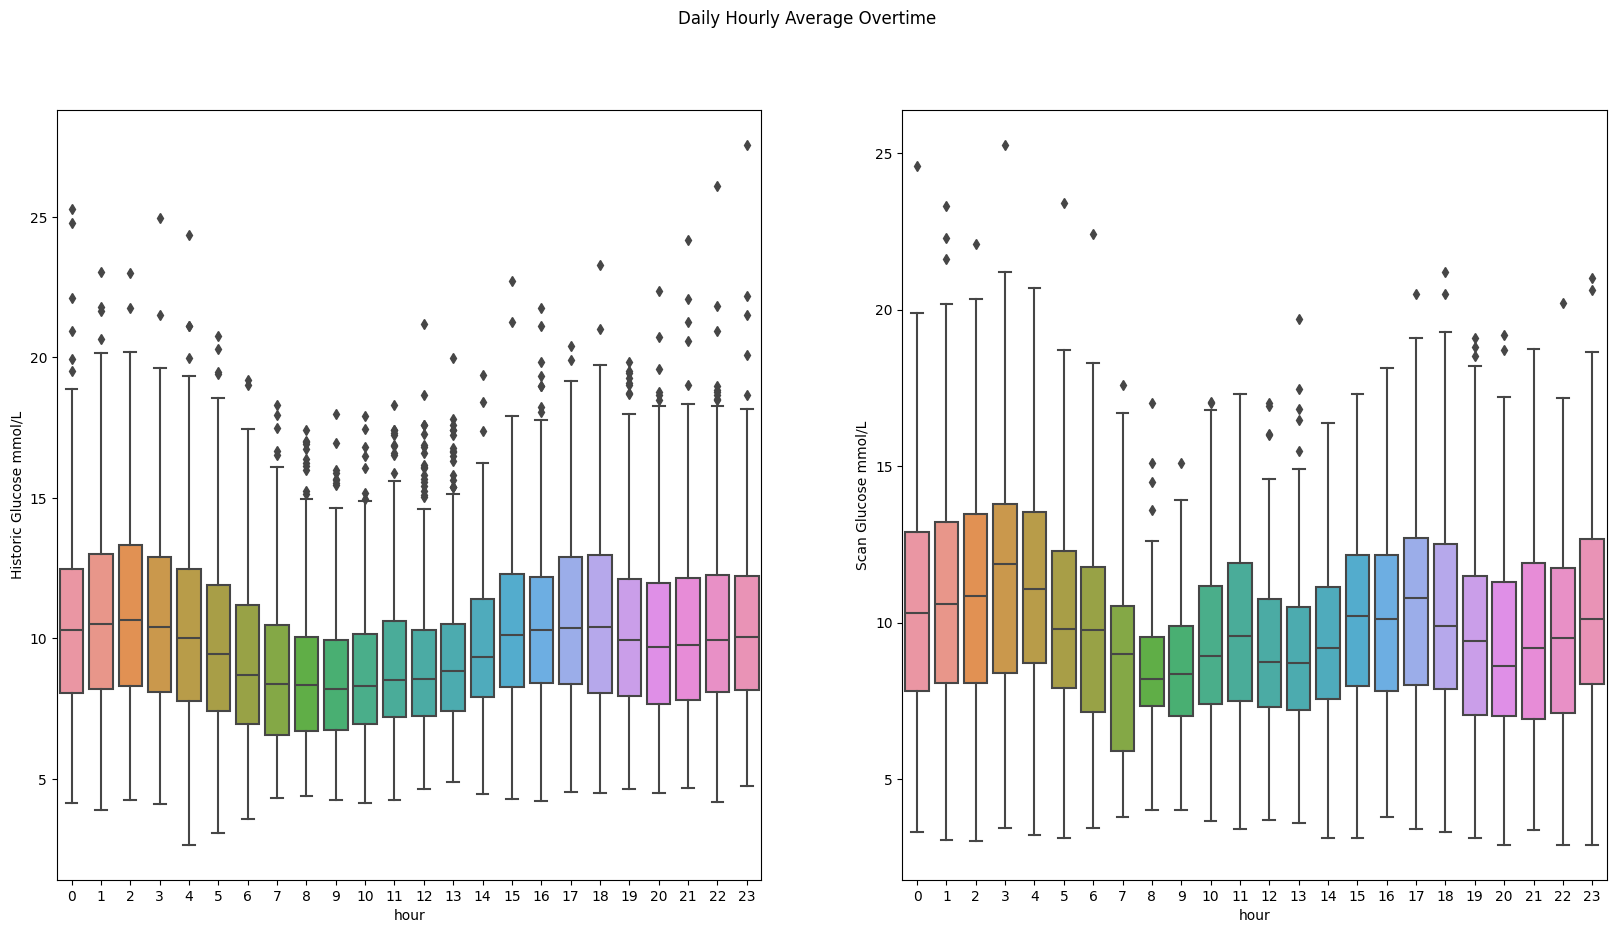

In [285]:
cgm_df_uc['date'] = cgm_df_uc['Device Timestamp'].dt.date
cgm_df_uc['hour'] = cgm_df_uc['Device Timestamp'].dt.hour
cgm_df_uc['weekday'] = cgm_df_uc['Device Timestamp'].dt.weekday

historic_scan_glucose = cgm_df_uc.groupby(['date','weekday','hour'])[['Historic Glucose mmol/L','Scan Glucose mmol/L']].mean().reset_index()

# analyse the historic, and scan glucose overtime from an hourly statistical view

fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.boxplot(y=historic_scan_glucose['Historic Glucose mmol/L'], x=historic_scan_glucose['hour'], ax=axs[0])
sns.boxplot(y=historic_scan_glucose['Scan Glucose mmol/L'], x=historic_scan_glucose['hour'], ax=axs[1])
plt.suptitle('Daily Hourly Average Overtime');

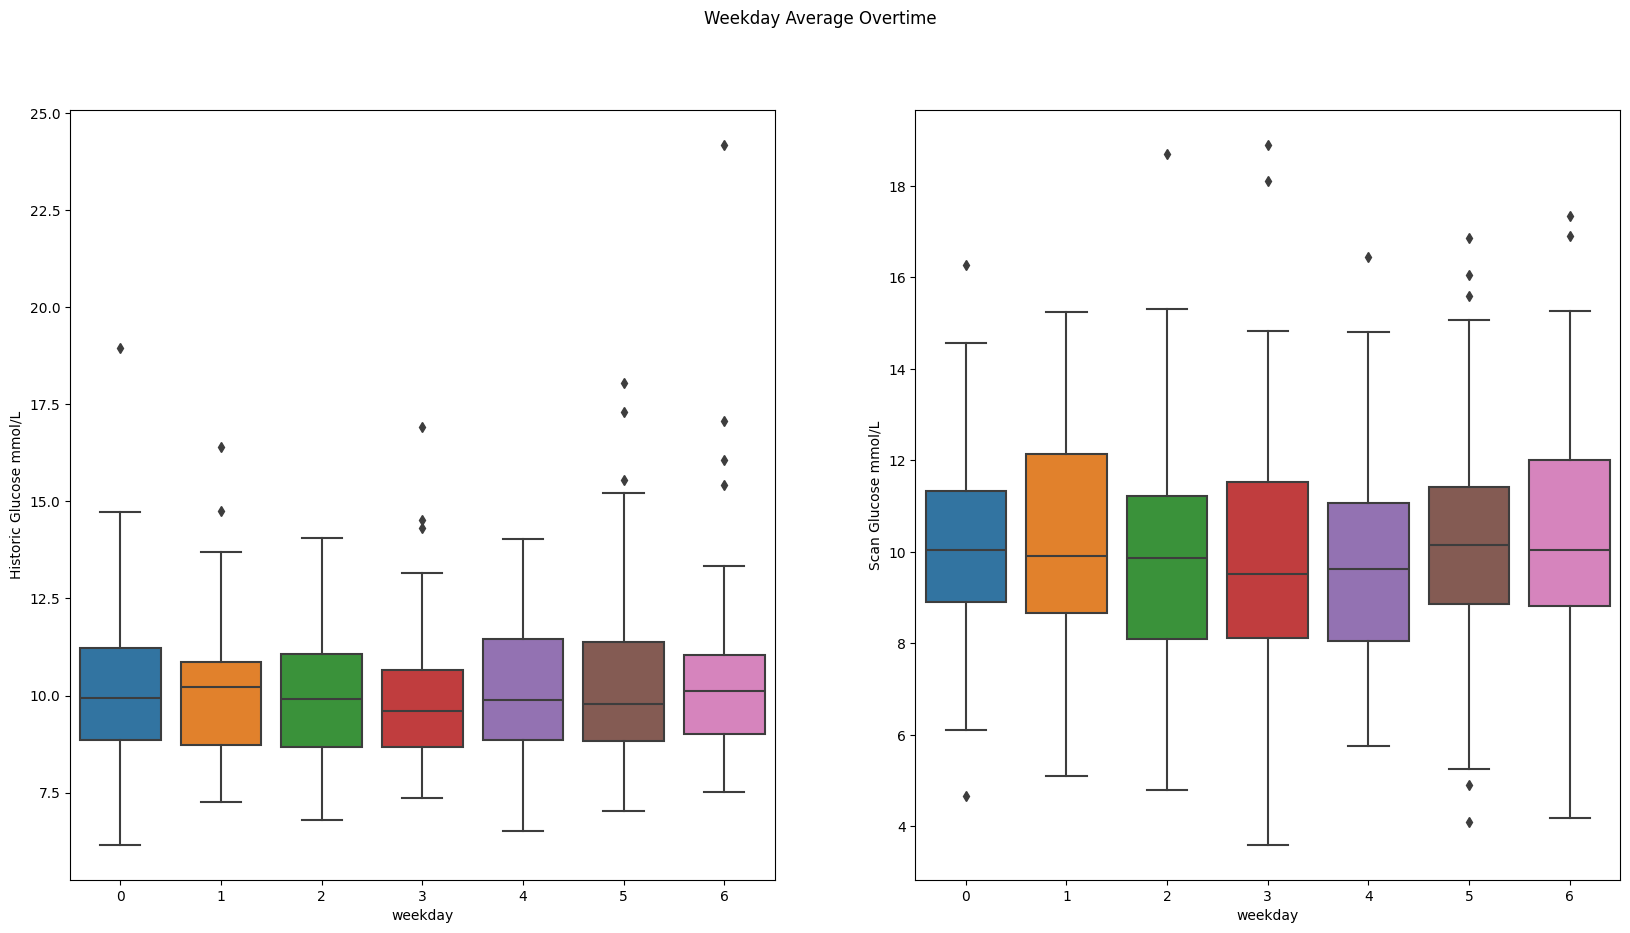

In [286]:
historic_scan_glucose_wd = cgm_df_uc.groupby(['date','weekday'])[['Historic Glucose mmol/L','Scan Glucose mmol/L']].mean().reset_index()
fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.boxplot(y=historic_scan_glucose_wd['Historic Glucose mmol/L'], x=historic_scan_glucose_wd['weekday'], ax=axs[0])
sns.boxplot(y=historic_scan_glucose_wd['Scan Glucose mmol/L'], x=historic_scan_glucose_wd['weekday'], ax=axs[1])
plt.suptitle('Weekday Average Overtime');

#### Time series analysis

<Axes: xlabel='date', ylabel='Scan Glucose mmol/L'>

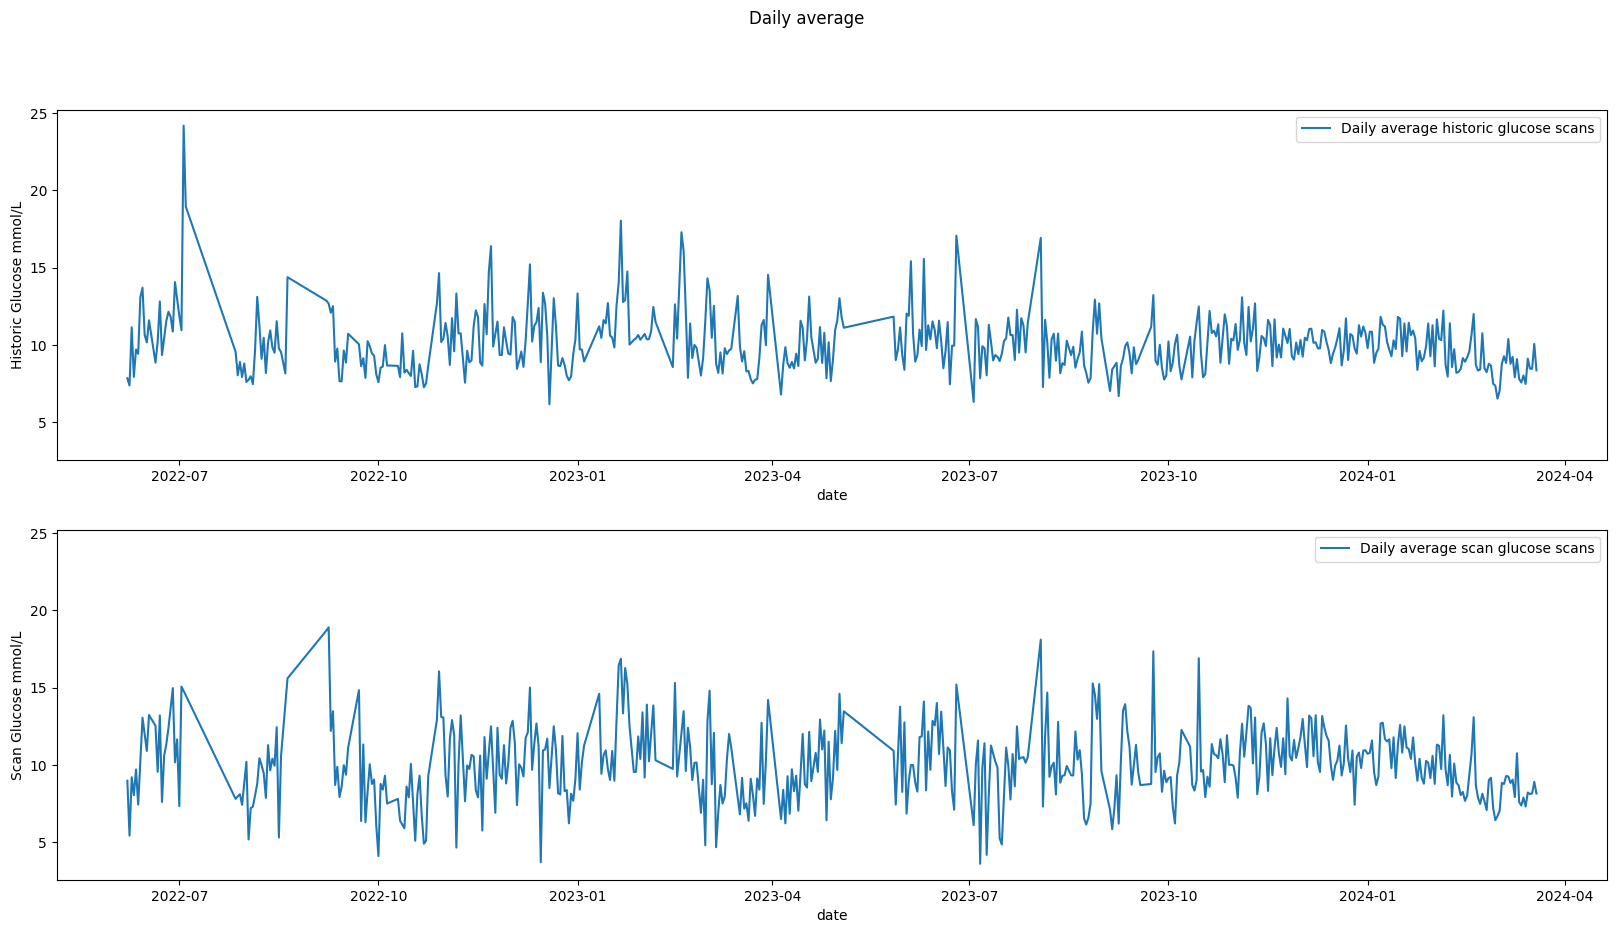

In [287]:
# daily average
historic_scan_glucose_daily = cgm_df_uc.groupby(['date'])[['Historic Glucose mmol/L','Scan Glucose mmol/L']].mean().reset_index().set_index('date')

# plot daily average for both historic and scan 
fig,axs = plt.subplots(2,1, figsize=(20,10), sharey=True)
sns.lineplot(y=historic_scan_glucose_daily['Historic Glucose mmol/L'],x=historic_scan_glucose_daily.index, ax=axs[0], label='Daily average historic glucose scans')
plt.suptitle('Daily average')
sns.lineplot(y=historic_scan_glucose_daily['Scan Glucose mmol/L'], x=historic_scan_glucose_daily.index, ax=axs[1], label='Daily average scan glucose scans')

Text(0.5, 1.0, 'Percentage difference between scans and historical')

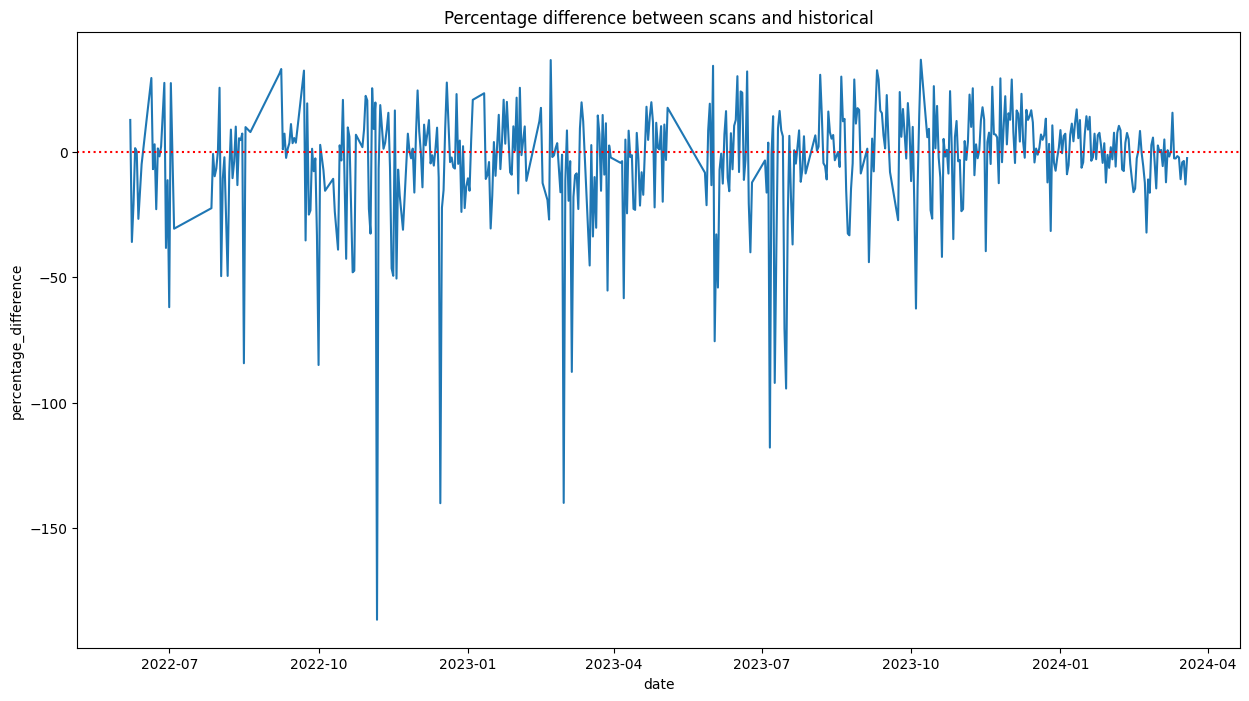

In [288]:
# view the percetage difference between the scan and historic on a daily basis
# shows there are sf differences between the scan and historic values

historic_scan_glucose_daily['percentage_difference'] = (historic_scan_glucose_daily['Scan Glucose mmol/L'] - historic_scan_glucose_daily['Historic Glucose mmol/L'])/historic_scan_glucose_daily['Scan Glucose mmol/L']*100
fig, ax  = plt.subplots(figsize=(15,8))
sns.lineplot(historic_scan_glucose_daily['percentage_difference'])
ax.axhline(0, c='red', ls=':')
plt.title('Percentage difference between scans and historical')

In [289]:

historic_scan_glucose_daily

,Historic Glucose mmol/L,Scan Glucose mmol/L,percentage_difference
date,,,
2022-06-07,7.839623,8.975000,1.265044e+01
2022-06-08,7.380208,5.427273,-3.598374e+01
2022-06-09,11.137097,9.200000,-2.105540e+01
2022-06-10,7.928421,8.042857,1.422829e+00
2022-06-11,9.700000,9.700000,-1.831296e-14
...,...,...,...
2024-03-15,9.109375,8.209589,-1.096018e+01
2024-03-16,8.458947,8.115918,-4.226620e+00
2024-03-17,8.457895,8.155932,-3.702367e+00


Text(0.5, 0.98, 'Moving average of historic vs scanned glucose')

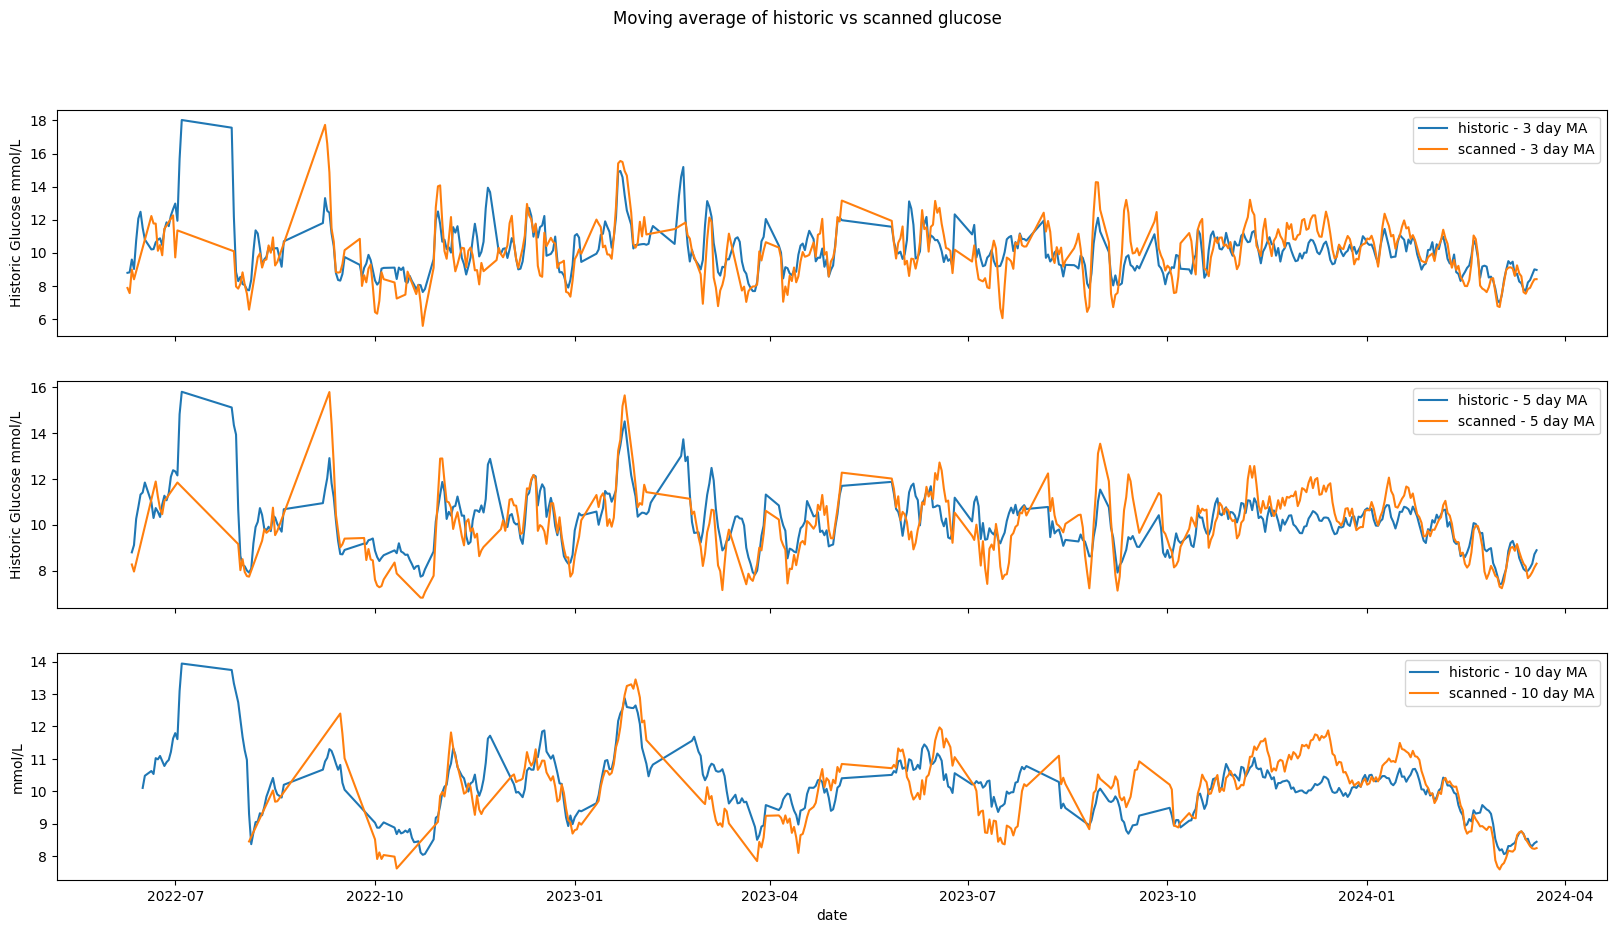

In [290]:
# 3 day rolling average of the scan vs historic glucose readings 

fig,axs = plt.subplots(3,1, figsize=(20,10), sharex=True)
sns.lineplot(historic_scan_glucose_daily['Historic Glucose mmol/L'].rolling(3).mean(), label='historic - 3 day MA', ax=axs[0])
sns.lineplot(historic_scan_glucose_daily['Scan Glucose mmol/L'].rolling(3).mean(), label='scanned - 3 day MA',  ax=axs[0])
plt.ylabel('mmol/L')
sns.lineplot(historic_scan_glucose_daily['Historic Glucose mmol/L'].rolling(5).mean(), label='historic - 5 day MA', ax=axs[1])
sns.lineplot(historic_scan_glucose_daily['Scan Glucose mmol/L'].rolling(5).mean(), label='scanned - 5 day MA',  ax=axs[1])
plt.ylabel('mmol/L')
sns.lineplot(historic_scan_glucose_daily['Historic Glucose mmol/L'].rolling(10).mean(), label='historic - 10 day MA',  ax=axs[2])
sns.lineplot(historic_scan_glucose_daily['Scan Glucose mmol/L'].rolling(10).mean(), label='scanned - 10 day MA',  ax=axs[2])
plt.ylabel('mmol/L')
plt.suptitle('Moving average of historic vs scanned glucose')

Text(0.5, 0.98, 'Daily range of blood glucose readings')

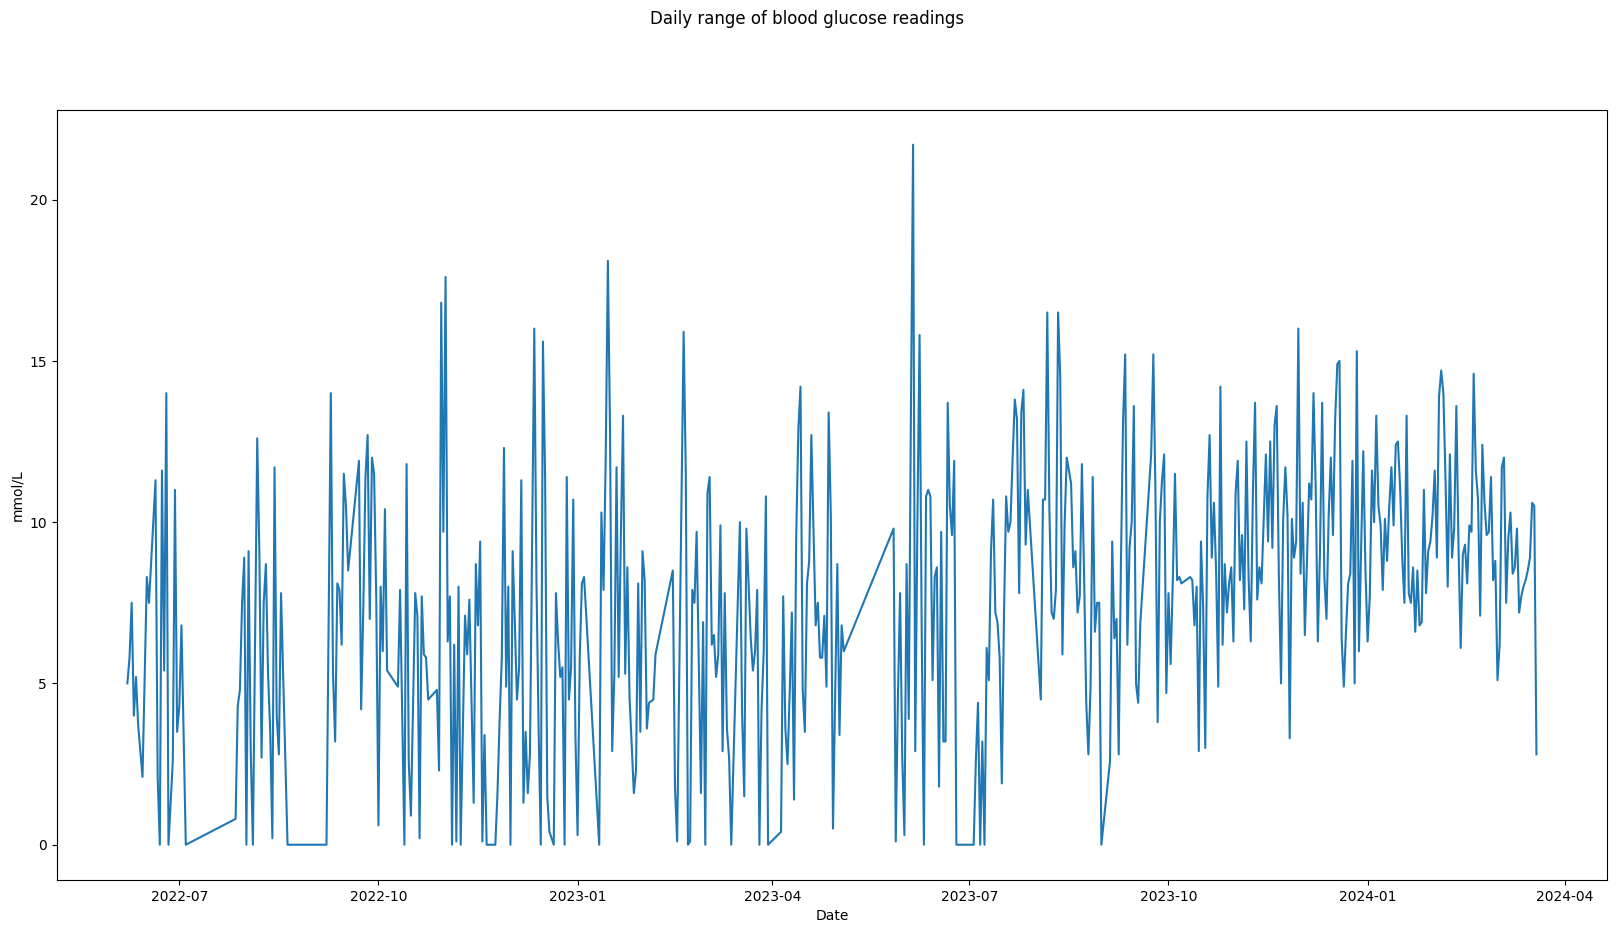

In [291]:
# Given that the scanned data seems to be more likely to be accurate ...? Let's use that for the following analysis:
cgm_data_scanned['Date'] = cgm_data_scanned.index.date
fig, ax = plt.subplots(figsize=(20,10))
daily_range = cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].max() - cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].min() 
sns.lineplot(daily_range)
plt.ylabel('mmol/L')
plt.suptitle('Daily range of blood glucose readings')


Text(0.5, 0.98, 'Total number of scans per day')

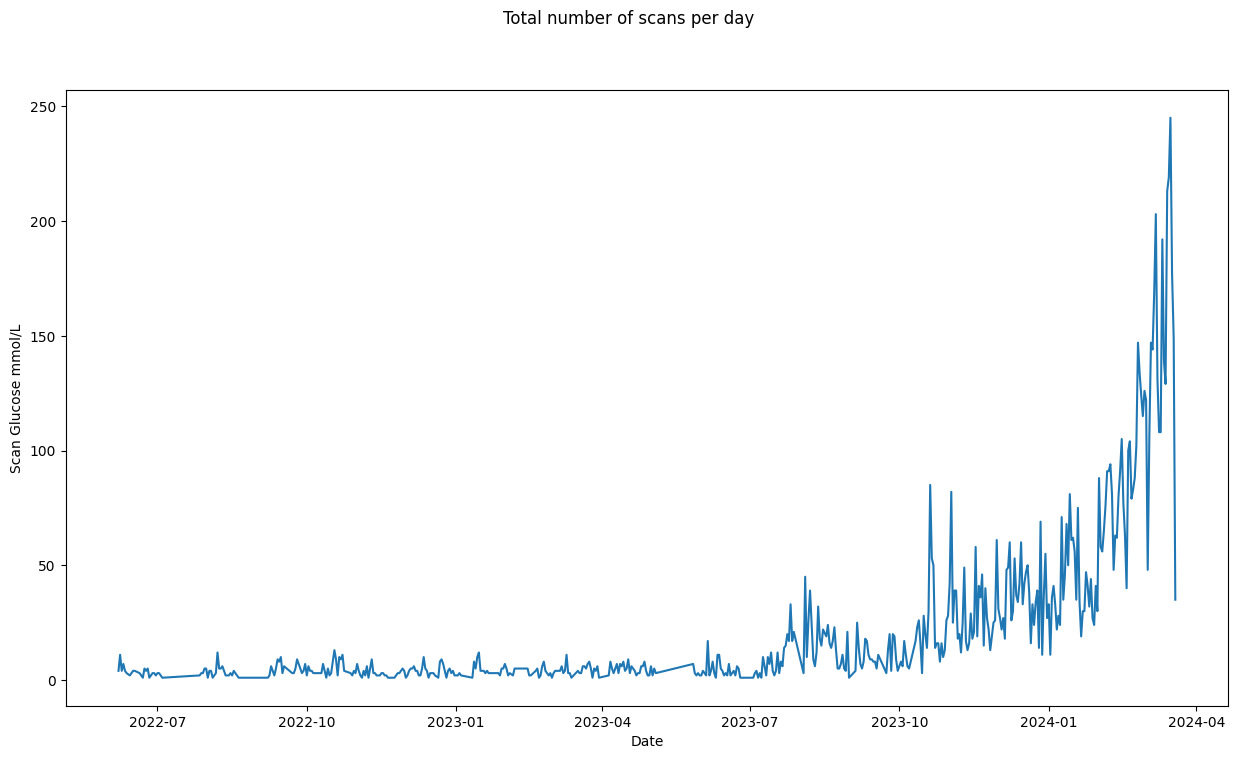

In [292]:
# question is this data available in CGM, or just FGMs?
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].count())
plt.suptitle('Total number of scans per day')

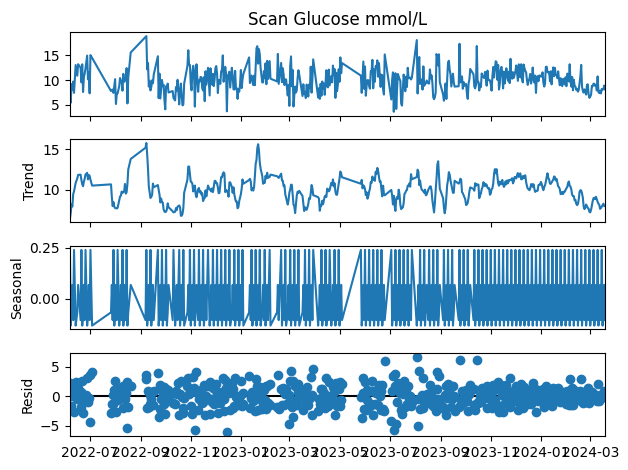

In [293]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].mean()
# cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].mean()

daily_average_scanned_glucose = cgm_data_scanned.groupby('Date')['Scan Glucose mmol/L'].mean()
daily_average_scanned_glucose.index = pd.to_datetime(daily_average_scanned_glucose.index)

res = seasonal_decompose(daily_average_scanned_glucose, extrapolate_trend='freq', model='additive', period=5)
res.plot();

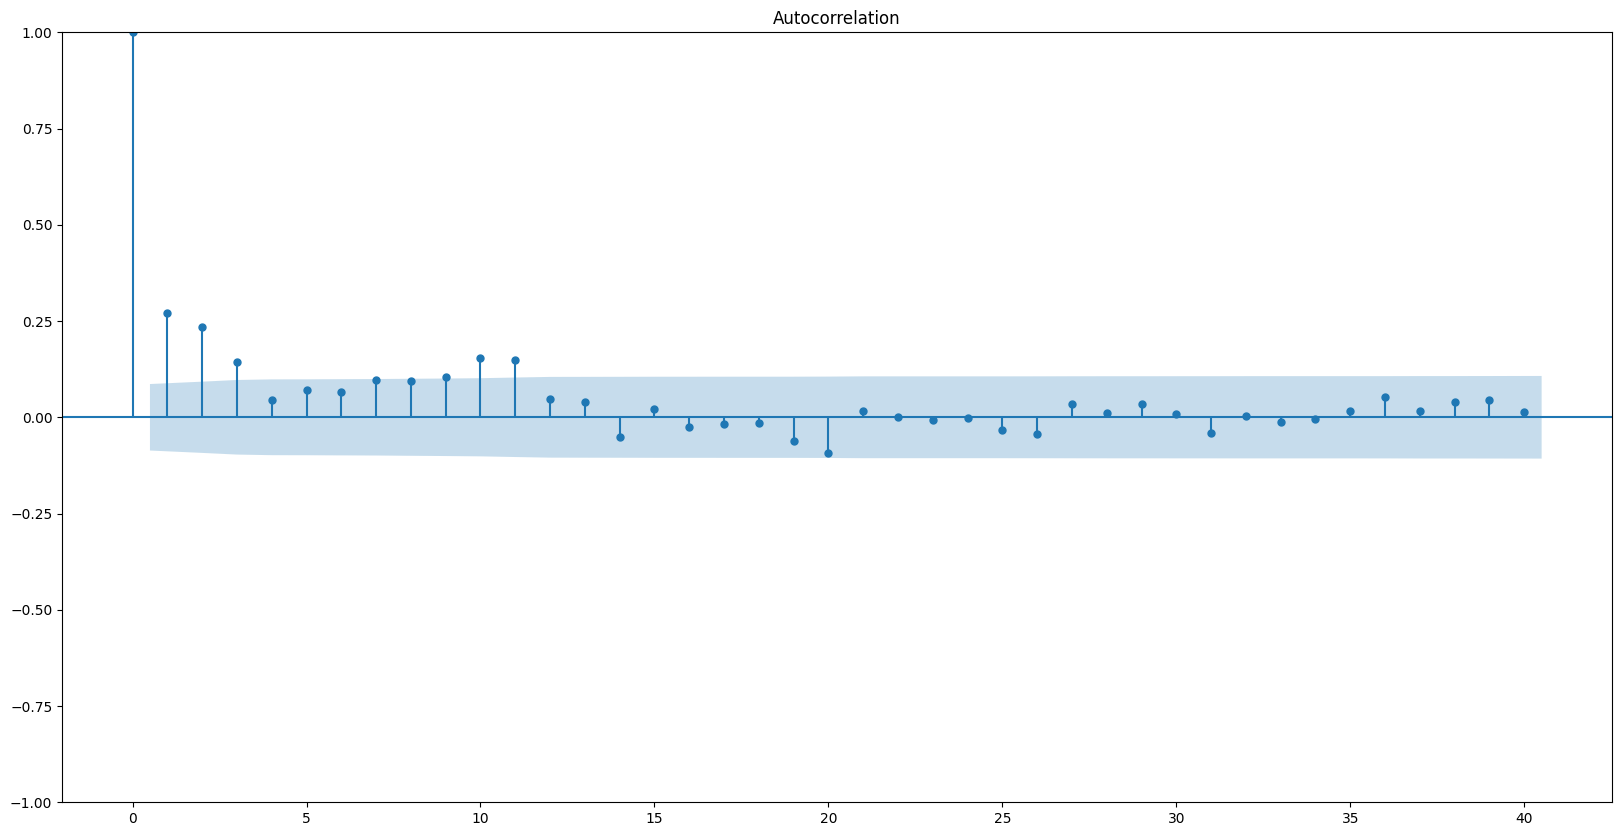

In [294]:
# plot the acf 
from statsmodels.graphics.tsaplots import plot_acf
fig, ax= plt.subplots(figsize=(20,10))
plot_acf(daily_average_scanned_glucose, ax=ax, lags=40)
plt.show()